In [1]:
import math
import matplotlib.pyplot as plt
import copy


def u_pi_2_y(y):
    return y


def u_0y(y):
    return 0


def u_x0(x):
    return 0


def u_x1(x):
    return math.sin(x)


def solve_f(x, y):
    return y * math.sin(x)


class EllipticalSolver:
    """ 6 вариант """
    def __init__(self, h1, h2, x_interval, y_interval):
        self.y_beg = y_interval[0]
        self.y_end = y_interval[1]
        self.x_beg = x_interval[0]
        self.x_end = x_interval[1]
        self.h1 = h1
        self.h2 = h2
        self.N1 = int((x_interval[1] - x_interval[0]) / h1)
        self.N2 = int((y_interval[1] - y_interval[0]) / h2)
        self.u = [[0 for column in range(self.N1 + 1)] for row in range(self.N2 + 1)]

    def _borders_filling(self):
        for i in range(self.N2 + 1):
            self.u[i][0] = u_0y(i * self.h2)
            self.u[i][self.N1] = u_pi_2_y(i * self.h2)
        for j in range(self.N1 + 1):
            self.u[0][j] = u_x0(j * self.h1)
            self.u[self.N2][j] = u_x1(j * self.h1)

    def _internal_nodes_filling(self):
        for i in range(1, self.N2):
            f1 = self.u[i][0]
            f2 = self.u[i][self.N1]
            x1 = self.x_beg
            x2 = self.x_end
            for j in range(1, self.N1):
                self.u[i][j] = f1 + (f2 - f1) / (x2 - x1) * (self.h1 * j - x1)

    def _calc_norm(self, m):
        max_in_rows = []
        for row in m:
            max_in_rows.append(max(row, key=lambda x: abs(x)))
        return max(max_in_rows, key=lambda x: abs(x))

    def _matrix_difference(self, l, r):
        diff = [[0 for column in range(self.N1 + 1)] for row in range(self.N2 + 1)]
        for i in range(0, self.N2 + 1):
            for j in range(0, self.N1 + 1):
                diff[i][j] = l[i][j] - r[i][j]

        return diff

    def Libman(self, e=0.01):
        self._borders_filling()
        self._internal_nodes_filling()
        prev_u = [[0 for column in range(self.N1 + 1)] for row in range(self.N2 + 1)]
        cur_u = self.u
        self.iter = 0
        diff = self._matrix_difference(cur_u, prev_u)
        while self._calc_norm(diff) > e:
            self.iter += 1
            prev_u = cur_u
            cur_u = copy.deepcopy(prev_u)
            for i in range(1, self.N2):
                for j in range(1, self.N1):
                    cur_u[i][j] = (self.h2 ** 2 * prev_u[i - 1][j] + self.h2 ** 2 * prev_u[i + 1][j]
                                   + self.h1 ** 2 * prev_u[i][j - 1] + self.h1 ** 2 * prev_u[i][j + 1]) \
                                  / (2 * self.h2 ** 2 + 2 * self.h1 ** 2 - self.h1 ** 2 * self.h2 ** 2)
            diff = self._matrix_difference(cur_u, prev_u)

        self.u = cur_u

    def Relaxation(self, r, e=0.01):
        self._borders_filling()
        self._internal_nodes_filling()
        cur_u = self.u
        prev_u = [[0 for column in range(self.N1 + 1)] for row in range(self.N2 + 1)]
        self.iter = 0
        diff = self._matrix_difference(cur_u, prev_u)
        while self._calc_norm(diff) > e:
            self.iter += 1
            prev_u = cur_u
            cur_u = copy.deepcopy(prev_u)
            for i in range(1, self.N2):
                for j in range(1, self.N1):
                    piece1 = self.h1 ** 2 * cur_u[i - 1][j] + self.h2 ** 2 * cur_u[i][j - 1] \
                             + self.h1 ** 2 * prev_u[i + 1][j] + self.h2 ** 2 * prev_u[i][j + 1]
                    piece2 = self.h1 ** 2 * self.h2 ** 2 * (-prev_u[i][j])
                    piece3 = 2 * self.h1 ** 2 + 2 * self.h2 ** 2
                    cur_u[i][j] = ((piece1 - piece2) / piece3 - (1 - 1 / r) * prev_u[i][j]) * r
            diff = self._matrix_difference(cur_u, prev_u)

        self.u = cur_u

    def Seidel(self, e=0.01):
        self.Relaxation(r=1, e=e)

    def Analytical_solution(self):
        u = [[0 for column in range(self.N1 + 1)] for row in range(self.N2 + 1)]
        for i in range(0, self.N2 + 1):
            for j in range(0, self.N1 + 1):
                u[i][j] = solve_f(j * self.h1, i * self.h2)
        return u

    def y_const_plot(self, interval):
        fig = plt.figure(figsize=(10, 80))
        for k in range(interval[0], interval[1] + 1):
            ax = fig.add_subplot(interval[1] - interval[0] + 1, 1, k + 1 - interval[0])
            ax.set(ylim=[-1, 1], xlim=[0, math.pi / 2])
            ax.set_title(f"const y = {self.h2 * k} шаг разбиения {self.h2}")
            x = [self.h1 * j for j in range(self.N1 + 1)]
            u_x = self.u[k]
            plt.plot(x, u_x)
            answ = [solve_f(x_elem, self.h2 * k) for x_elem in x]
            ax.plot(x, answ, color="black")
        plt.show()

    def x_const_plot(self, interval):
        fig = plt.figure(figsize=(10, 80))
        for j in range(interval[0], interval[1] + 1):
            ax = fig.add_subplot(interval[1] - interval[0] + 1, 1, j + 1 - interval[0])
            ax.set(ylim=[-1, 1], xlim=[0, math.pi / 2])
            ax.set_title(f"const x = {self.h1 * j}")
            y = [self.h2 * k for k in range(self.N2 + 1)]
            u_y = [self.u[k][j] for k in range(self.N2 + 1)]
            plt.plot(y, u_y)
            answ = [solve_f(j * self.h1, y_elem) for y_elem in y]
            ax.plot(y, answ, color="black")
        plt.show()

    def get_error(self, k):
        error = 0
        x = [self.h1 * j for j in range(self.N1 + 1)]
        u_x = self.u[k]
        answ = [solve_f(x_elem, self.h2 * k) for x_elem in x]
        for i in range(self.N1 + 1):
            error += abs(answ[i] - u_x[i]) ** 2
        return math.sqrt(error) / self.N1


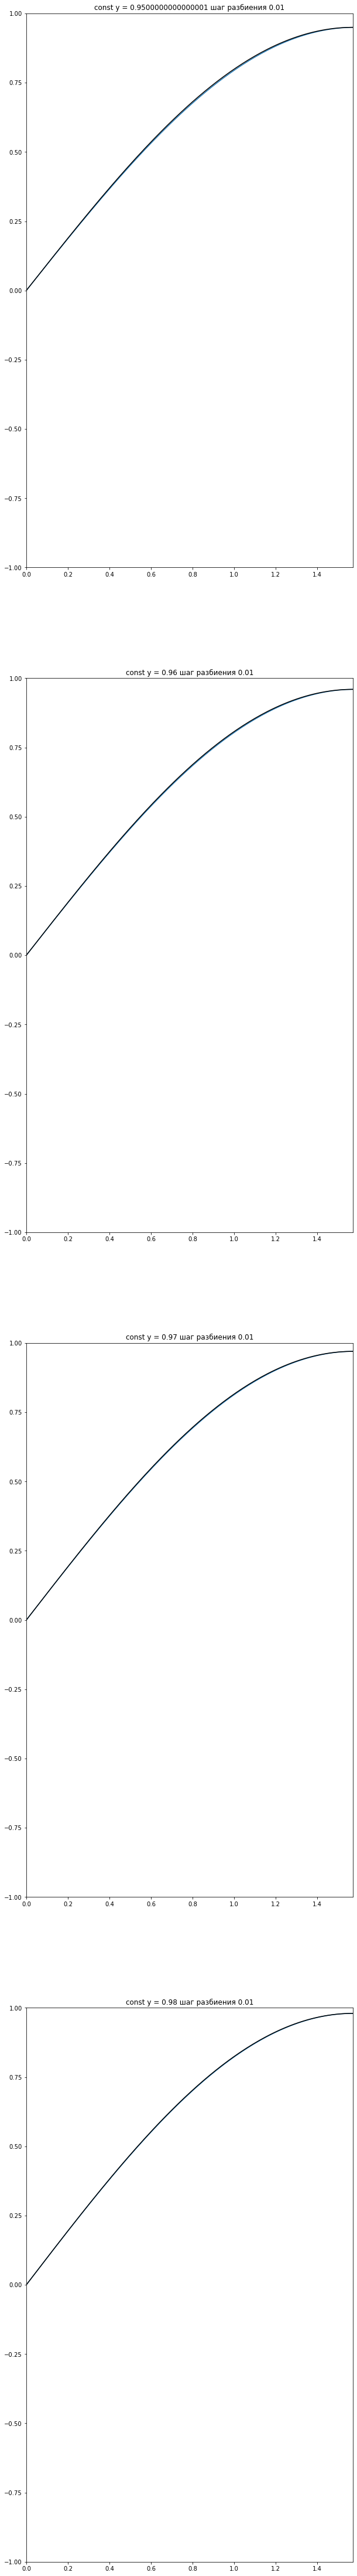

0.00028111715393724554
4592


In [6]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Libman(e=0.00001)
a.y_const_plot([95, 98])
print(a.get_error(95))
print(a.iter)

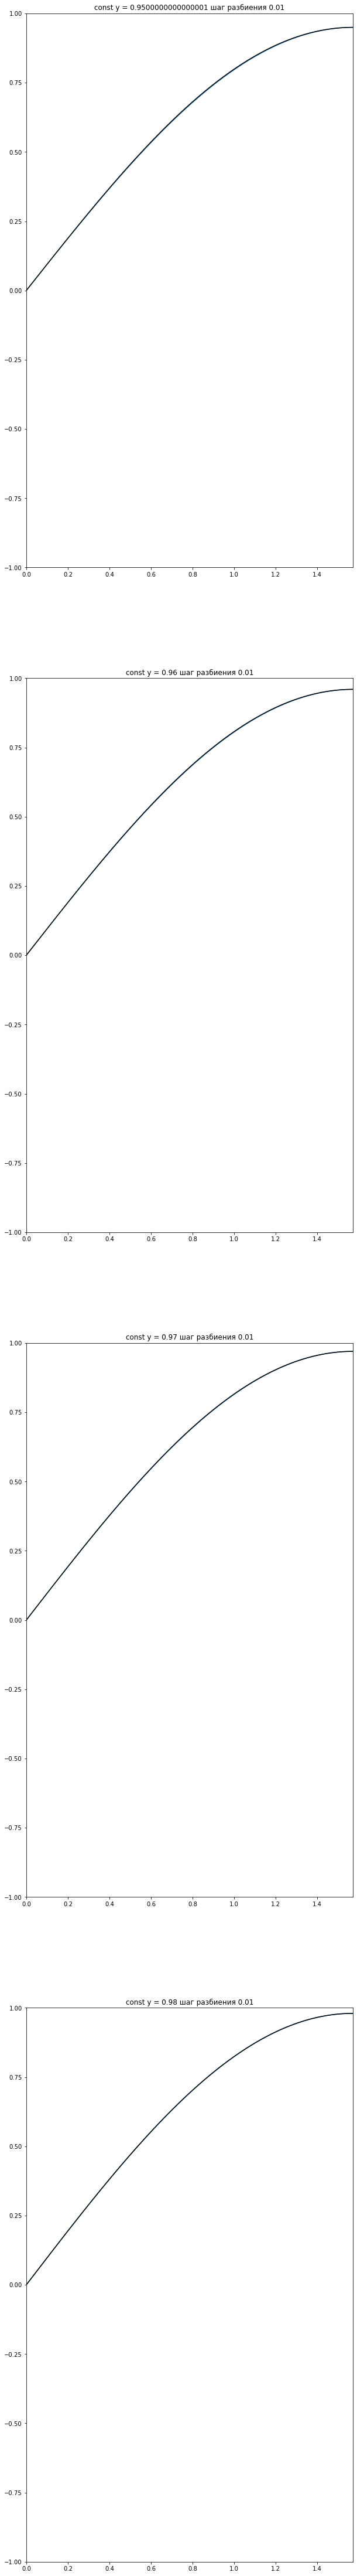

0.00013587615722877915
3385


In [7]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Seidel(e=0.00001)
a.y_const_plot([95, 98])
print(a.get_error(95))
print(a.iter)

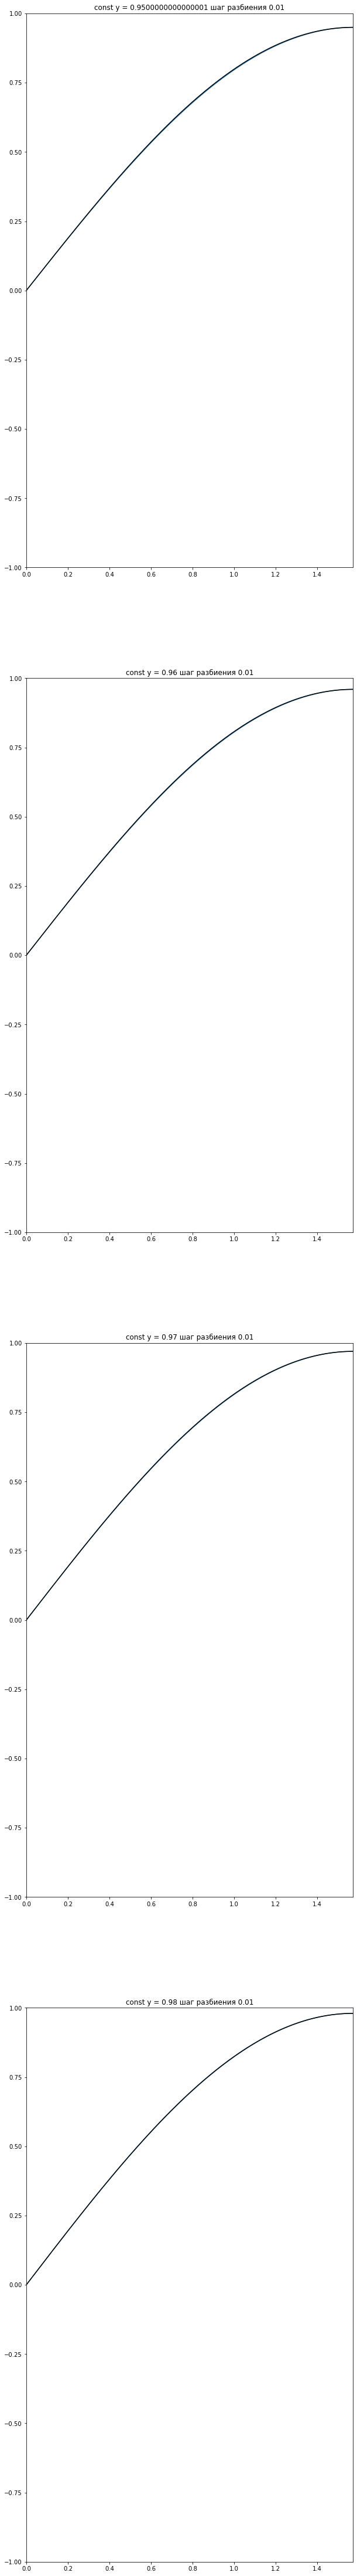

0.0001670956963190041
3752


In [64]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Relaxation(e=0.00001, r=0.9)
a.y_const_plot([95, 98])
print(a.get_error(95))
print(a.iter)

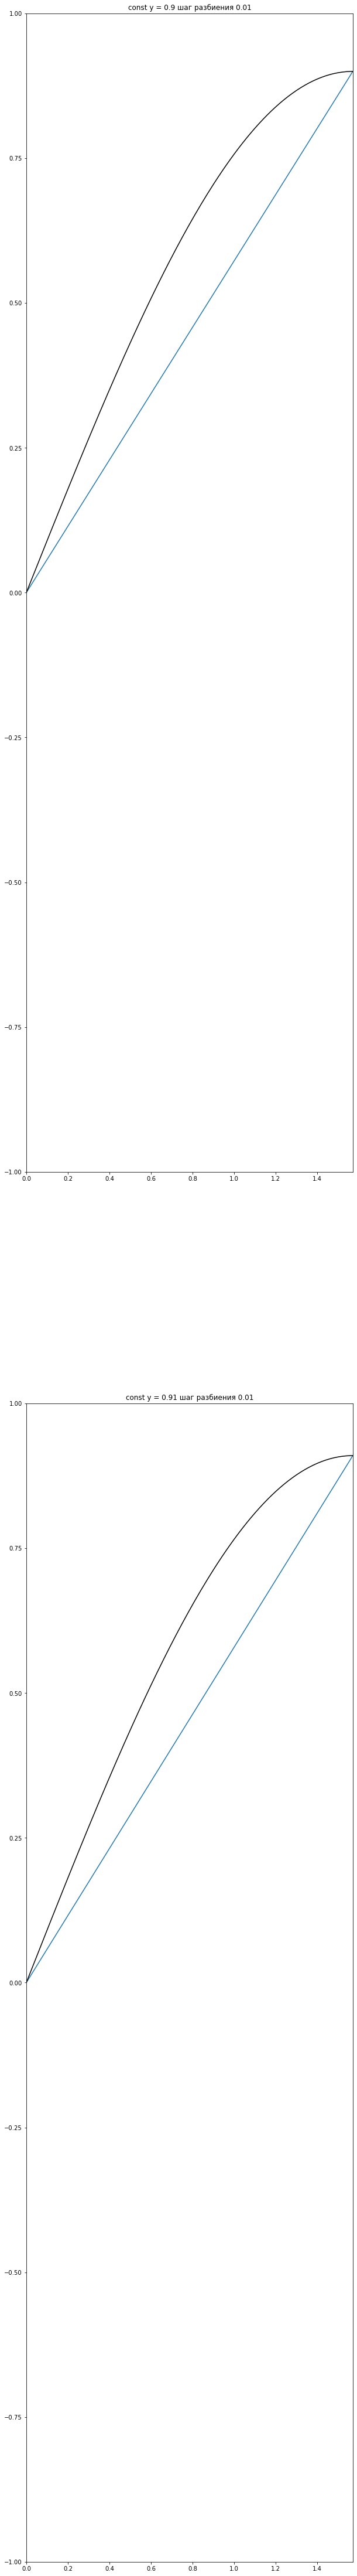

0.01144122227269889
1


In [5]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Libman(e=0.1)
a.y_const_plot([90, 91])
print(a.get_error(95))
print(a.iter)

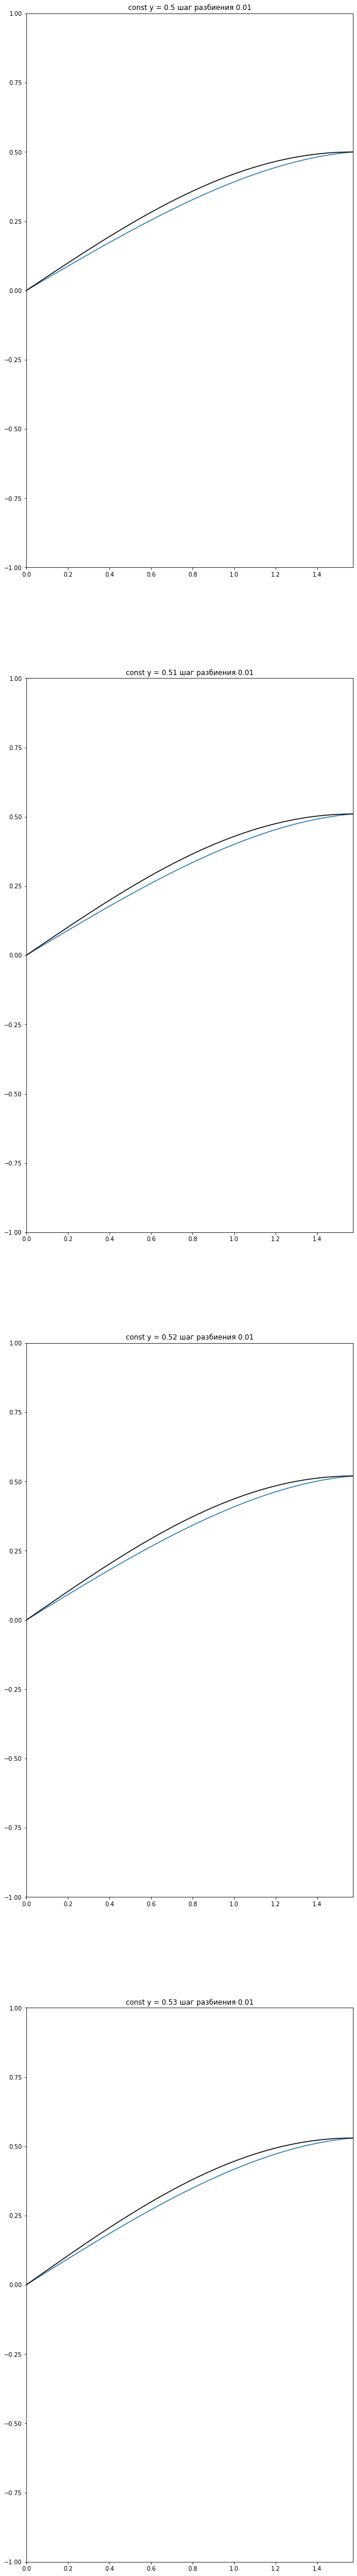

0.00028111715393724554
4592


In [8]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Libman(e=0.00001)
a.y_const_plot([50, 53])
print(a.get_error(95))
print(a.iter)

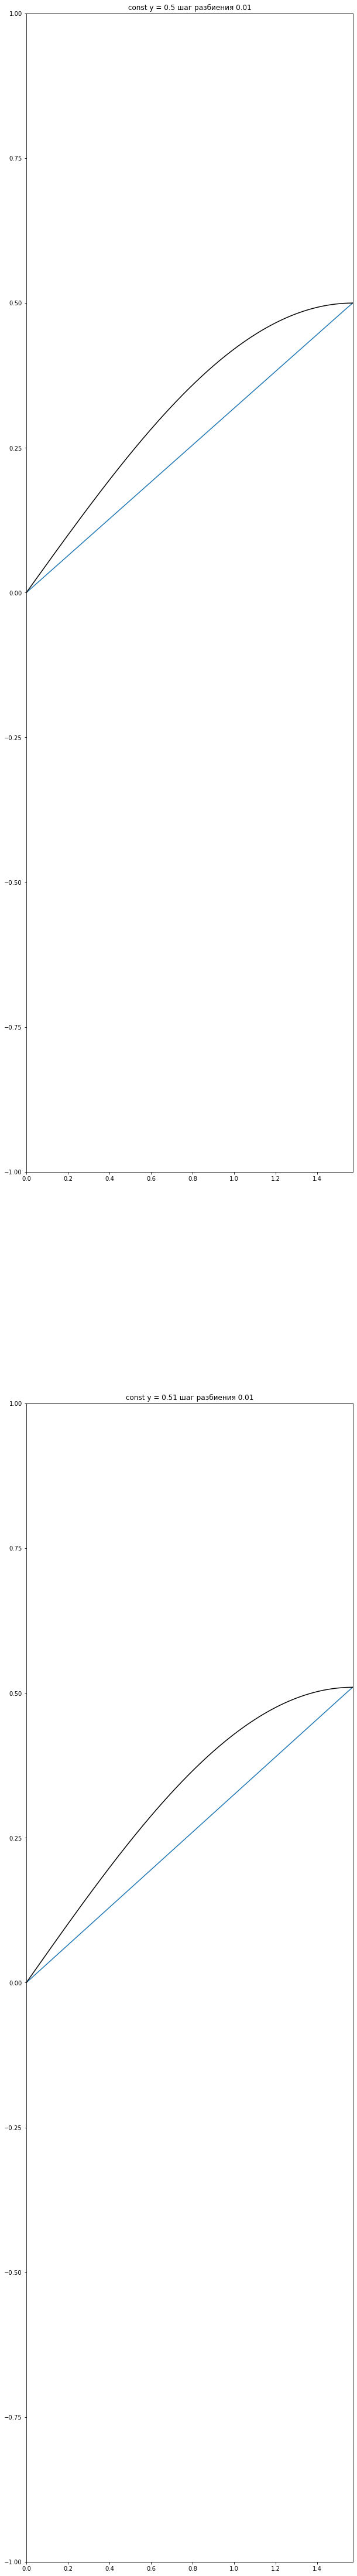

0.007446890275741079
52


In [8]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Libman(e=0.001)
a.y_const_plot([50, 51])
print(a.get_error(95))
print(a.iter)

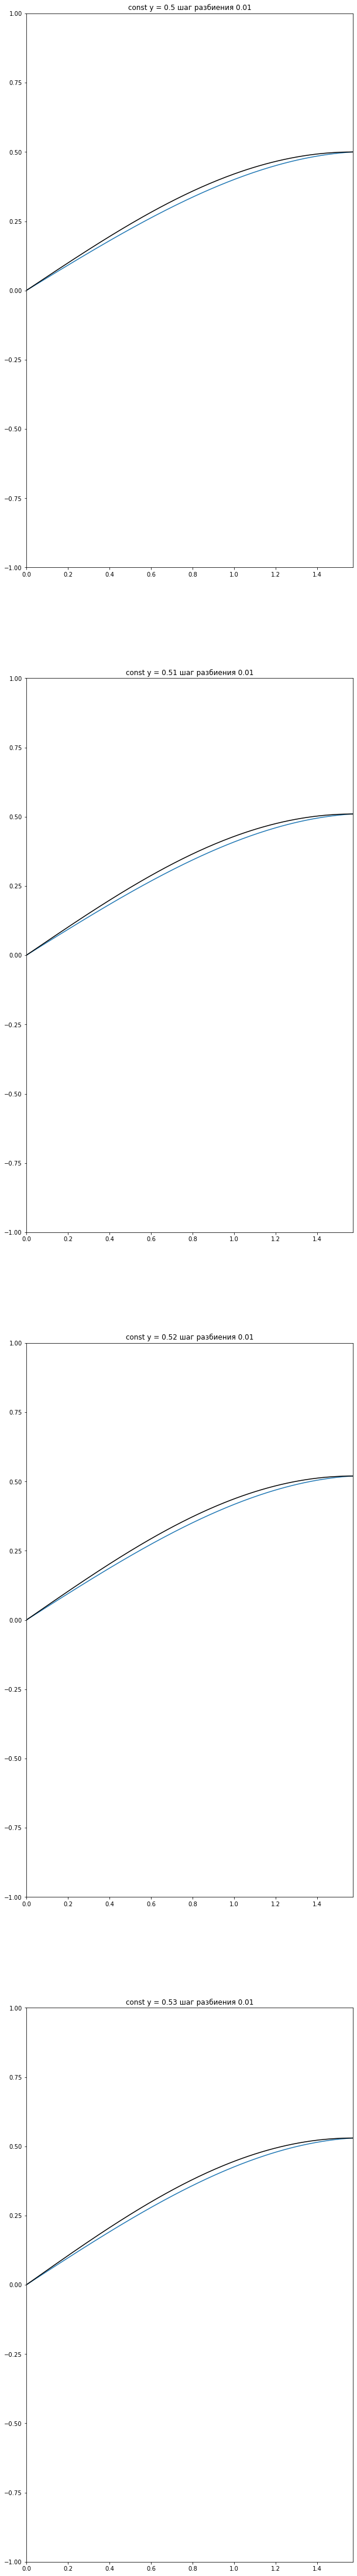

0.0012241950196415702
5683


In [15]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Libman(e=0.000007)
a.y_const_plot([50, 53])
print(a.get_error(50))
print(a.iter)

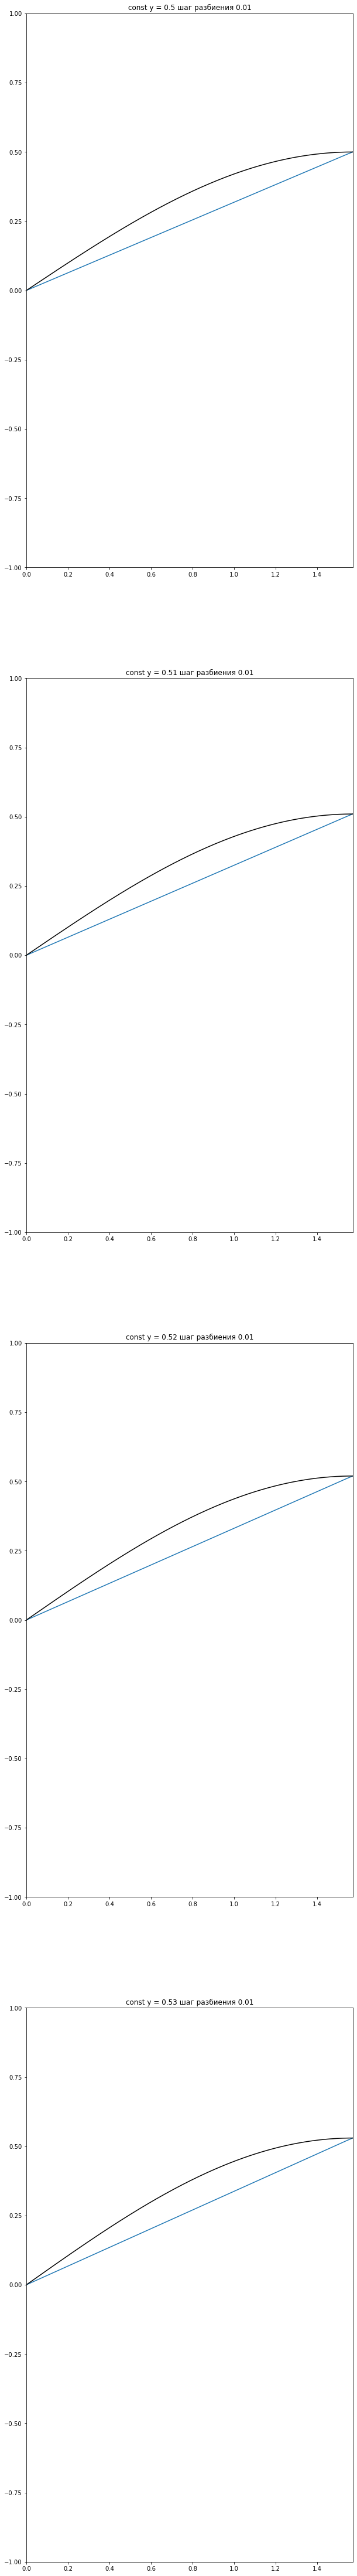

0.005987048794451376
74


In [4]:
a = EllipticalSolver(0.01, 0.01, [0, math.pi / 2], [0, 1])
a.Libman(e=0.0007)
a.y_const_plot([50, 53])
print(a.get_error(50))
print(a.iter)

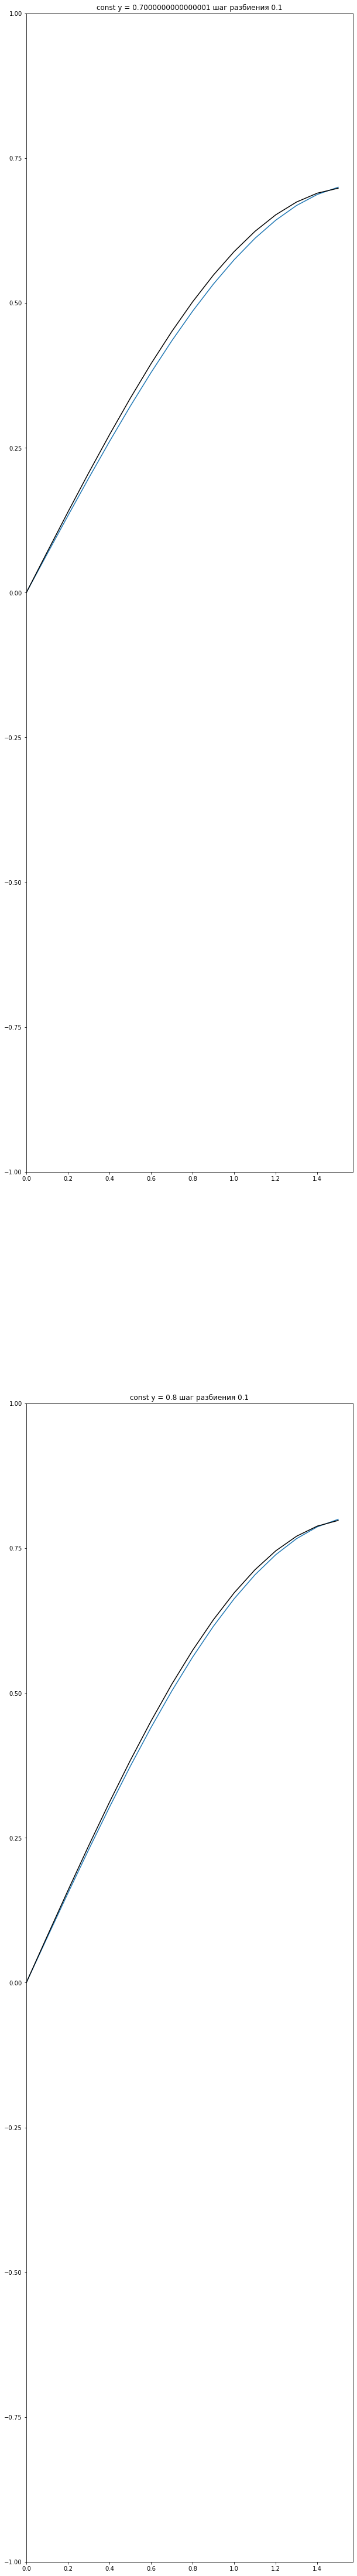

0.0029276757618592443
57


In [10]:
a = EllipticalSolver(0.1, 0.1, [0, math.pi / 2], [0, 1])
a.Libman(e=0.0007)
a.y_const_plot([7, 8])
print(a.get_error(7))
print(a.iter)